In [1]:
!pip install git+https://github.com/jkirkby3/pymle.git

  Cloning https://github.com/jkirkby3/pymle.git to c:\users\астемир\appdata\local\temp\pip-req-build-0847pa9b
  Resolved https://github.com/jkirkby3/pymle.git to commit 412f74f5201782686f13ed2c60acd07b740c42e8
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for pymle-diffusion: filename=pymle_diffusion-0.0.4-py3-none-any.whl size=41322 sha256=f3a3e8083cc905db8da35664dd2a194102296e6877bbf049ce0dc623c81e5c14
  Stored in directory: C:\Users\Астемир\AppData\Local\Temp\pip-ephem-wheel-cache-3ljdmvyg\wheels\0f\13\f6\83871fe3ee3c6831f6f8cc5989c9221b42b526ca31c5d0bf18
Successfully built pymle-diffusion


  Running command git clone --filter=blob:none --quiet https://github.com/jkirkby3/pymle.git 'C:\Users\Астемир\AppData\Local\Temp\pip-req-build-0847pa9b'


In [2]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np, scipy.stats as st

from scipy.stats import norm
from tqdm import tqdm
from pymle.models import CIR, CKLS, OrnsteinUhlenbeck
from pymle.sim.Simulator1D import Simulator1D
from pymle.core.TransitionDensity import ExactDensity, KesslerDensity, OzakiDensity, EulerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE

In [3]:
# Define auxiliary function to find minimal value
def argmin(iterable):
    return min(enumerate(iterable), key=lambda x: x[1])[0]

Task 1. Constant Maturity Interest Rates. Fit models (CEV, CIR, OU, CKLS) to a sample of historical interest rates over the period Jan 1, 1962 to till now. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using MLE approach.

The estimated parameters display in a table for each method. Calculate the AIC and select the best model. Compare your results with paper by Kirkby et. al (https://arxiv.org/abs/2108.12649) where the period from Jan 1, 1962 to April 8, 2021 (14,801 daily observations).

Dataset: Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (DGS10),
https://fred.stlouisfed.org/series/DGS10  

In [5]:
# Read data and preprocessing it
df_IR = pd.read_csv('DGS10.csv')
df_IR = df_IR[df_IR['DGS10'] != '.']

# Make valid numerical sample
sample = df_IR['DGS10'].values
sample = [float(sample[i]) for i in range(len(sample))]
sample = np.array(sample)

Task. Download the DGS10 dataset directlly from https://fred.stlouisfed.org/series/DGS10 .

Hint.

Use  
`from pymle.data.loader import load_10yr_CMrate`

In [6]:
df_IR.head()


,DATE,DGS10
0,2019-10-31,1.69
1,2019-11-01,1.73
2,2019-11-04,1.79
3,2019-11-05,1.86
4,2019-11-06,1.81


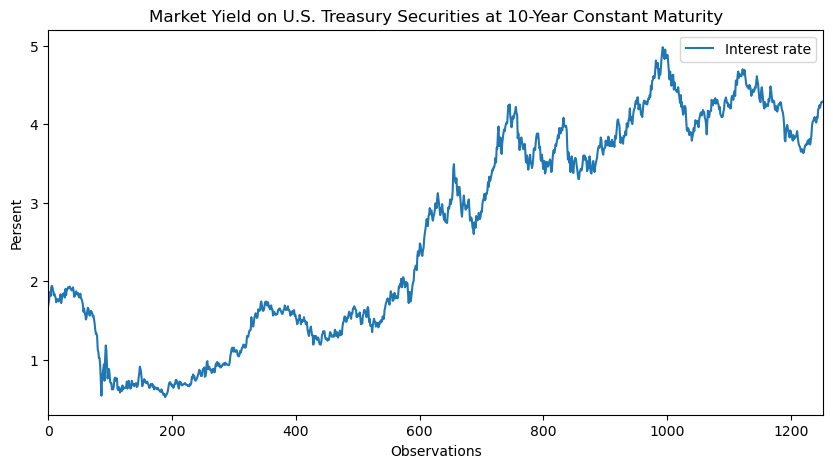

In [8]:
# Plot
figure, ax = plt.subplots(figsize=(10,5))
ax.plot(np.linspace(0, len(sample), len(sample)),sample, label='Interest rate')
plt.title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')
plt.xlim(0, len(sample))
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.show()

Task. Change the X marks to dates.

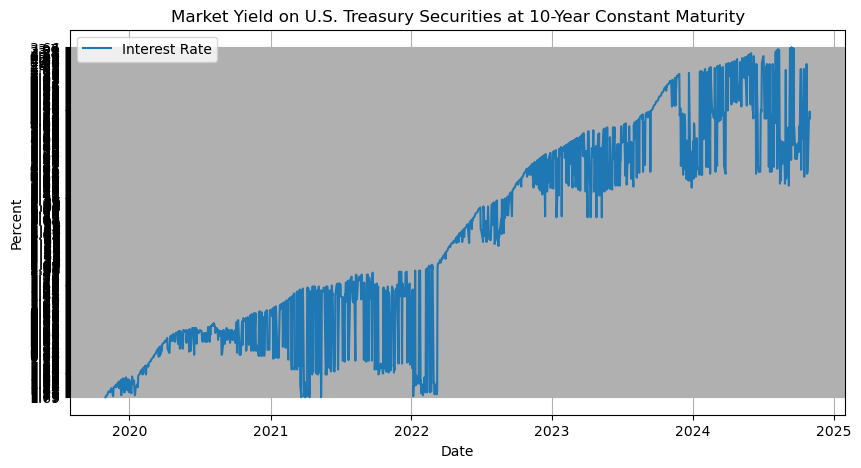

In [ ]:
# dates = pd.to_datetime(df_IR['DATE']) 
# sample = df_IR['DGS10'].values  


# fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(dates, sample, label='Interest Rate') 
# plt.title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')


# plt.ylabel('Percent')
# plt.xlabel('Date')
# plt.legend()
# plt.grid(True)
# plt.show()

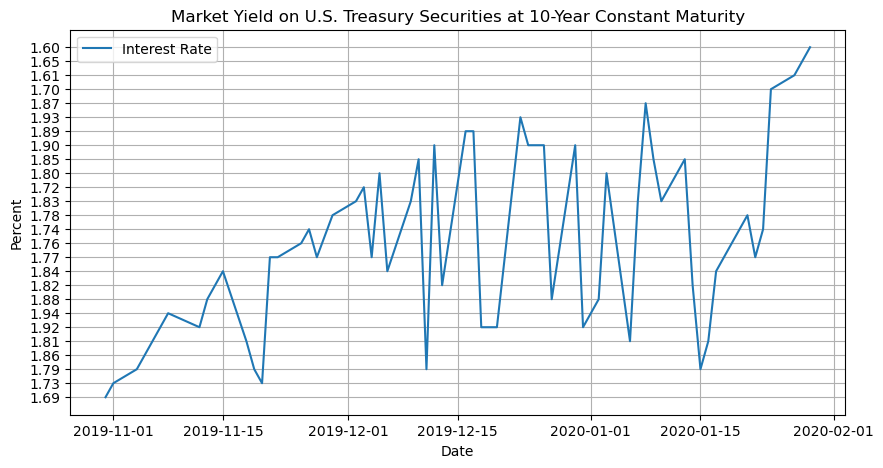

In [24]:
dates = pd.to_datetime(df_IR['DATE']) 
sample = df_IR['DGS10'].values  


fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dates[:60], sample[:60], label='Interest Rate') 
plt.title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')


plt.ylabel('Percent')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Import models for fitting:
from pymle.models import BrownianMotion, CEV, CIR,\
                         CKLS, GeometricBM, IGBM, \
                         OrnsteinUhlenbeck

In [31]:
# a) fit using Kessler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(float(0.01), float(10)), (float(0.01), float(2))],  # Brownian Motion
                [(float(0.01), float(10)), (float(0.01), float(10)), (float(0.01), float(10)), (float(0.01), float(2))], # CEV
                [(float(0.01), float(10)), (float(0.01), float(10)),(float(0.01), float(2))],  # CIR
                [(float(0.01), float(10)), (float(0.01), float(2))],  # GBM
                [(float(0.01), float(10)), (float(0.01), float(10)),(float(0.01), float(2))],  # IGBM
                [(float(0.01), float(10)), (float(0.01), float(10)),(float(0.01), float(2))],  # OU
                [(float(0.01), float(10)), (float(0.01), float(10)), (float(0.01), float(10)), (float(0.01), float(2))]  # CKLS
               ]

param_guess  = [[float(0.01), float(0.2)],                         # Brownian Motion
                [float(0.01), float(0.01), float(0.01), float(0.2)],  # CEV
                [float(0.01), float(0.01), float(0.2)],             # CIR
                [float(0.01), float(0.2)],                         # GBM
                [float(0.01), float(0.01), float(0.2)],             # IGBM
                [float(0.01), float(0.01), float(0.2)],             # OU
                [float(0.01), float(0.01), float(0.01), float(0.2)]  # CKLS
               ]


# Set parameters for estimators:
dt = 1. / 252

# Estimate max likelyhood, using KesslerDensity
kessler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))]
kessler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))]

Initial Params: [0.01, 0.2]


TypeError: '>' not supported between instances of 'str' and 'int'

In [32]:
best_ind = argmin(kessler_est)
print("AIC values for Kessler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     kessler_est[0], model_name[0], kessler_params[0],\
     kessler_est[1], model_name[1], kessler_params[1],\
     kessler_est[2], model_name[2], kessler_params[2],\
     kessler_est[3], model_name[3], kessler_params[3],\
     kessler_est[4], model_name[4], kessler_params[4],\
     kessler_est[5], model_name[5], kessler_params[5],\
     kessler_est[6], model_name[6], kessler_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], kessler_params[best_ind]))

NameError: name 'kessler_est' is not defined

In [ ]:
# b) fit using Shoji-Ozaki method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
shoji_ozaki_est      = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
shoji_ozaki_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

In [17]:
best_ind = argmin(shoji_ozaki_est)
print("AIC values for Shoji-Ozaki estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     shoji_ozaki_est[0], model_name[0], shoji_ozaki_params[0],\
     shoji_ozaki_est[1], model_name[1], shoji_ozaki_params[1],\
     shoji_ozaki_est[2], model_name[2], shoji_ozaki_params[2],\
     shoji_ozaki_est[3], model_name[3], shoji_ozaki_params[3],\
     shoji_ozaki_est[4], model_name[4], shoji_ozaki_params[4],\
     shoji_ozaki_est[5], model_name[5], shoji_ozaki_params[5],\
     shoji_ozaki_est[6], model_name[6], shoji_ozaki_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], shoji_ozaki_params[best_ind]))

AIC values for Shoji-Ozaki estimation:
       -38847.409 - BrownianMotion model with params [0.01005923 1.03341988],
       -40523.303 - CEV model with params [0.01341305 0.13225896 0.55893576 0.33752845],
       -40075.054 - CIR model with params [0.0105578  0.1294673  0.43176856],
       -33248.895 - GeometricBM model with params [0.0175265  0.23224451],
       -33268.502 - IGBM model with params [0.16158014 4.8843974  0.23103106],
       -38846.006 - OrnsteinUhlenbeck model with params [0.01608839 0.37856729 1.03343189],
       -40522.463 - CKLS model with params [0.01006219 0.01000384 0.55886086 0.33759827],
       
The best model is CEV     with param [0.01341305 0.13225896 0.55893576 0.33752845]


In [ ]:
# c) fit using Euler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
eu_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

In [19]:
best_ind = argmin(euler_est)
print("AIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est[0], model_name[0], eu_params[0],\
     euler_est[1], model_name[1], eu_params[1],\
     euler_est[2], model_name[2], eu_params[2],\
     euler_est[3], model_name[3], eu_params[3],\
     euler_est[4], model_name[4], eu_params[4],\
     euler_est[5], model_name[5], eu_params[5],\
     euler_est[6], model_name[6], eu_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], eu_params[best_ind]))

AIC values for Euler estimation:
       -38847.409 - BrownianMotion model with params [0.01005921 1.03341988],
       -40524.515 - CEV model with params [0.05070551 5.2913834  0.55876099 0.33767644],
       -40076.438 - CIR model with params [0.05063563 5.1143611  0.4317396 ],
       -33248.895 - GeometricBM model with params [0.01727279 0.23225258],
       -33268.503 - IGBM model with params [0.16250357 4.85747828 0.23095634],
       -38846.589 - OrnsteinUhlenbeck model with params [0.04644465 5.13957658 1.03337866],
       -40522.464 - CKLS model with params [0.01001144 0.01000052 0.55887201 0.33759819],
       
The best model is CEV     with param [0.05070551 5.2913834  0.55876099 0.33767644]


In [20]:
print("For the best model {}\n \
    params are:\n \
    {},\n \
    {},\n \
    {}".format(
    model_name[best_ind],\
    kessler_params[best_ind],\
    shoji_ozaki_params[best_ind],\
    eu_params[best_ind]))

For the best model CEV
     params are:
     [0.06005312 0.2116363  0.56040116 0.33662824],
     [0.01341305 0.13225896 0.55893576 0.33752845],
     [0.05070551 5.2913834  0.55876099 0.33767644]


In [24]:
shoji_ozaki_p = [0.01190742, 0.6541825, 0.57703004, 0.32514395]
kessler_p     = [0.02011782, 0.13874663, 0.567096, 0.33594728]
euler_p       = [0.06504598, 5.87897445, 0.57674668, 0.32538039]

Task: Rewrite code and pass estimated parameters programmatically.

In [ ]:
# your code

In [21]:
# Generate a CEV process with estimated parameters
# Define auxiliary functions:
def Wiener_proc(N, T):
    W = np.zeros(N)
    delta = T / N
    sqrt_delta = np.sqrt(delta)
    for i in range (1, N):
        W[i] += W[i-1] + rnd.normal(0, sqrt_delta)
    return W

#  CEV process:
def CEV_pr(S, kappa, mu, sigma, gamma, dt, dW):
    dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW
    return dS

In [22]:
cW = [sample[i] - sample[i-1] for i in range(1, len(sample))]

<ipython-input-21-73405076d682>:13: RuntimeWarning: invalid value encountered in scalar power
  dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW


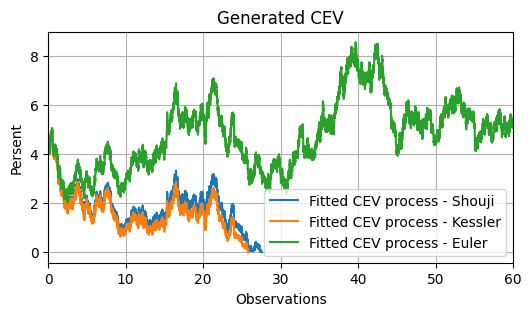

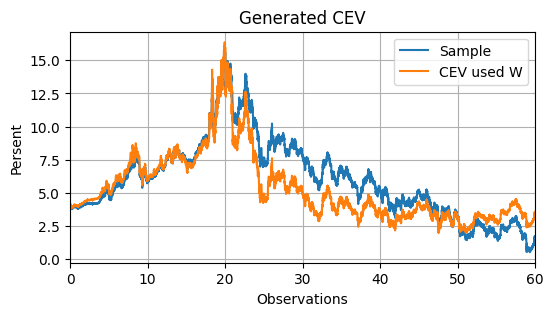

In [35]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cev_s[i] = cev_s[i-1] + CEV_pr(cev_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    cev_k[i] = cev_k[i-1] + CEV_pr(cev_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW)
    cev_e[i] = cev_e[i-1] + CEV_pr(cev_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)
    ecev[i] = ecev[i-1] + CEV_pr(ecev[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, cev_s, label="Fitted CEV process - Shouji")
plt.plot(time_line, cev_k, label="Fitted CEV process - Kessler")
plt.plot(time_line, cev_e, label="Fitted CEV process - Euler")
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label='CEV used W')
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

Task. Generate a CKLS process with estimated parameters.

In [ ]:
# your code

In [ ]:
# a) fit using Euler method:

# Choose several models:
model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

#pb = param_bounds[0]
#pg = np.array([1., 0.5])
#m = BrownianMotion()

# Set parameters for estimators:
dt = 1. / 252
K = 1
eu_params = []
oz_params = []
so_params = []
ks_params = []
ex_params = []

#euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    eu_params.append(euler_est)
    oz_params.append(ozaki_est)
    so_params.append(shoji_est)
    ks_params.append(kessler_est)
    ex_params.append(exact_est)

Task. Calculate the BIC and select the best model. Compare results with solution of Task 1.

In [ ]:
# your code

In [30]:
# Implement multiprocessing approach for solving
import multiprocessing
def MLE_Estimator(i):
    # a) fit using Kessler method:

    # Choose several models:
    model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
             IGBM(), OrnsteinUhlenbeck(), CKLS()]

    # Create parametrization templates:
    param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                    [(0.01, 10), (0.01, 2)],                         # GBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
                   ]

    param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                    [0.01, 0.01, 0.01, 0.2],                         # CEV
                    [0.01, 0.01, 0.2],                               # CIR
                    [0.01, 0.2],                                     # GBM
                    [0.01, 0.01, 0.2],                               # IGBM
                    [0.01, 0.01, 0.2],                               # OU
                    [0.01, 0.01, 0.01, 0.2]                          # CKLS
                   ]

    #pb = param_bounds[0]
    #pg = np.array([1., 0.5])
    #m = BrownianMotion()

    # Set parameters for estimators:
    dt = 1. / 252
    K = 1
    eu_params = []
    oz_params = []
    so_params = []
    ks_params = []
    ex_params = []

    #euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

    for k in tqdm(range(K)):
        seed = rnd.randint(1, 10000)
        euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        eu_params.append(euler_est)
        oz_params.append(ozaki_est)
        so_params.append(shoji_est)
        ks_params.append(kessler_est)
        ex_params.append(exact_est)
    return [eu_params,
            oz_params,
            so_params,
            ks_params,
            ex_params]

In [ ]:
# Run estimator with parallel calculating:
K = 100
i_range   = [i for i in range(100)]
pool_obj = multiprocessing.Pool()
answer = pool_obj.map(MLE_Estimator, i_range)

Task 2. USD/Euro Exchange Rates.

Fit a time series of USD/EUR exchange rates over the period Jan 1, 1999 to till now (daily observations)  by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates display in a table for each method. Calculate the AIC and BIC and select the best model. Compare your results with paper (Kirkby et.al., 2022), where period was from Jan 1, 1999 to May 21, 2021 (daily observations).

Dataset: U.S./Euro Foreign Exchange Rate [DEXUSEU], retrieved from FRED, Federal Reserve Bank of St. Louis;
https://fred.stlouisfed.org/series/DEXUSEU

In [ ]:
# your code

Task 3. U.S. Interest Rates.

Fit a time series of IRates over the period  from 06/1964
to 12/1989 (monthly data) by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates
display in Table for each method. Calculate the AIC and BIC, and select the best model. Compare your results with paper by [Brouste et. al.](https://www.semanticscholar.org/paper/The-YUIMA-Project%3A-A-Computational-Framework-for-of-Brouste-Fukasawa/e9a4696779261dbeca55f316943307d7da5d3d1b) (page 43):

$$dX_t = (2.08 - 0.26 X_t)dt + 0.13 X^{1.44}_t dW_t.$$

Dataset: In order to obtain the data one can open browser, type the address https://rdrr.io/snippets/ and run the code in R language:



```
library(Ecdat)
data(Irates)
rates = Irates[, "r1"]; rates
plot(rates)
```



In [ ]:
# your code

Task 4.

Take a dual-listed security (for instance, Apple, Google, Amazon), which trade simultaneously on two exchanges. Fit a time series of spread over the 5 years period (day data) by CEV, CIR, OU, CKLS models.

For example, one can use the paper by [Bertram, 2009](https://https://www.sciencedirect.com/science/article/pii/S0378437109002829)
where a spread constructed on the dual-listed security, ANZ Bank (ANZ). Calculate the AIC and BIC, and select the best model.

Hint. Use refs for selection a dual-listed security. Calculate the AIC and BIC, and select the best model.

https://live.euronext.com/en/product/equities/US0378331005-MTAH

https://stockanalysis.com/list/indian-stocks-us/

In [ ]:
# your code